In [2]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation
from epymorph.parameter_fitting.utils import plots

In [3]:
import numpy as np

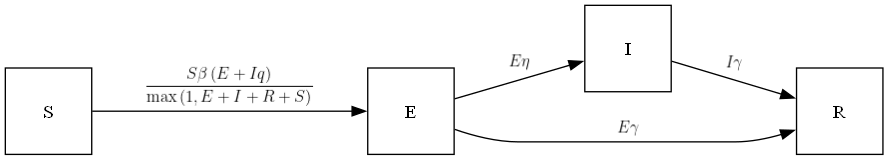

In [4]:
from epymorph import *  # noqa: F403
from epymorph.adrio import acs5, commuting_flows
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.seir import Seir
from epymorph.data.mm.pei import Pei

scope = StateScope.in_states(["AZ", "NM", "CO"], year=2015)
n_nodes = len(scope.includes)
initial_state = np.zeros(shape=(n_nodes, 4), dtype=np.int64)
initial_state[:, 0] = 100_000 - 10
initial_state[:, 1] = 20

rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Seir(),
    # Load an MM from the library
    mm=Pei(),
    # Use our scope
    scope=scope,
    init=init.Explicit(initials=initial_state),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2015-01-01", 120),
    # time_frame=TimeFrame.range("2015-01-01", "2015-01-01"),
    # Provide parameter values
    params={
        "beta": 0.4,
        "eta": 1 / 7,
        "gamma": 1 / 14,
        "q": 0.1,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
        "commuters": commuting_flows.Commuters(),
        # "commuters": c
    },
)

render(rume.ipm)

In [5]:
sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()

Loading epymorph.adrio.commuting_flows.Commuters:
  |####################| 100%  (7.168s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-01 (120 days)
• 3 geo nodes
  |####################| 100% 
Runtime: 0.065s


In [6]:
from epymorph.time import ByDate
from epymorph.tools.data import munge

data_df = munge(
    out,
    quantity=rume.ipm.select.events("E->I"),
    time=rume.time_frame.select.all().group(ByDate()).agg(),
    geo=rume.scope.select.all(),
)

In [11]:
data_df

,time,geo,E → I
0,2015-01-01,04,0
1,2015-01-01,08,1
2,2015-01-01,35,2
3,2015-01-02,04,4
4,2015-01-02,08,3
...,...,...,...
355,2015-04-29,08,6
356,2015-04-29,35,5
357,2015-04-30,04,4
358,2015-04-30,08,5


In [7]:
data_df.to_csv("./temp_synthetic_data.csv", index=False)

In [8]:
from pathlib import Path
from epymorph.adrio import acs5, csv

csvadrio = csv.CSVTimeSeries(
    file_path=Path("./temp_synthetic_data.csv"),
    time_col=0,
    time_frame=TimeFrame.range("2015-01-01", "2015-04-30"),
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [9]:
from epymorph.simulator.data import evaluate_param

params = {}

for key in rume.params:
    params[key] = np.array(evaluate_param(rume, str(key)))

rume_copy = SingleStrataRume(
    strata=rume.strata,
    ipm=rume.ipm,
    mms=rume.mms,
    scope=rume.scope,
    time_frame=rume.time_frame,
    params=params,
)

In [10]:
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.parameter_fitting.utils.resampler import ResamplingByNode

observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("E->I"),
        time=rume.time_frame.select.all().group(ByDate()).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=PoissonLikelihood(),
)

filter_type = ParticleFilter(num_particles=250, resampler=ResamplingByNode)

In [11]:
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_fitting.dynamics.dynamics import GeometricBrownianMotion
import scipy as sp

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=sp.stats.uniform(loc=0.1, scale=0.7),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    )
}

In [12]:
sim = FilterSimulation(
    rume=rume_copy,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

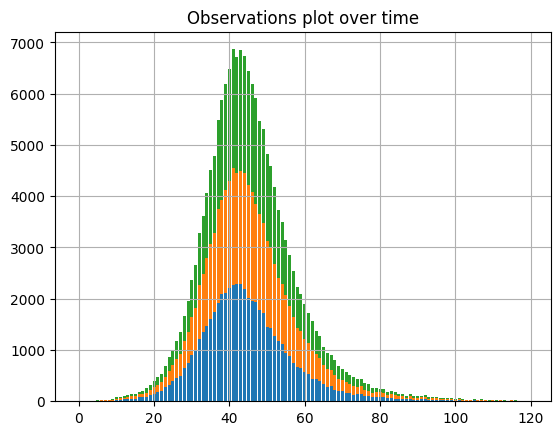

In [13]:
sim.plot_data()

In [14]:
output = sim.run()

Running Particle Filter simulation
• 2015-01-01 00:00:00 to 2015-04-30 00:00:00 (120 days)
• 250 particles

Simulation completed in 160.13s

Parameters estimated: ['beta']


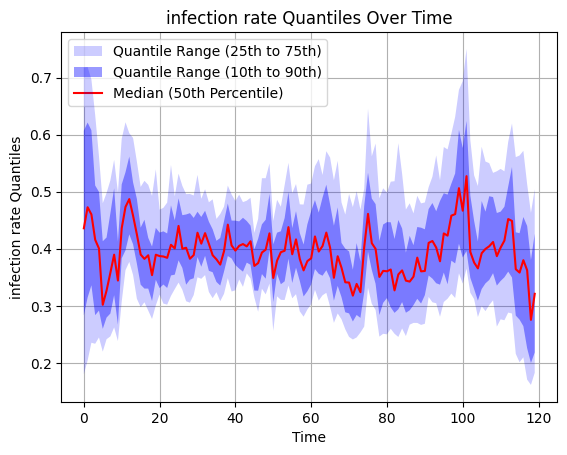

In [15]:
plots.params_plot(output=output, parameter="infection rate", node_index=0)

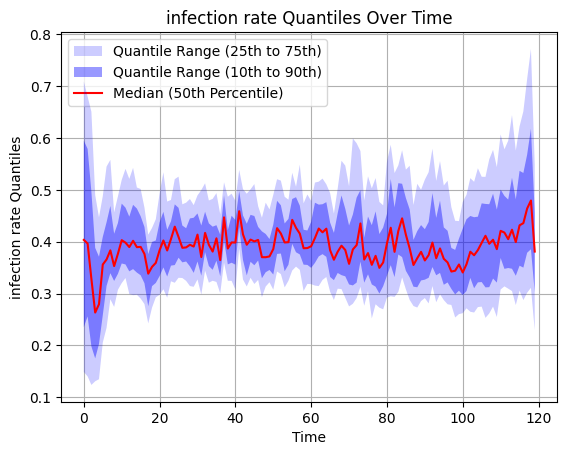

In [16]:
plots.params_plot(output=output, parameter="infection rate", node_index=1)

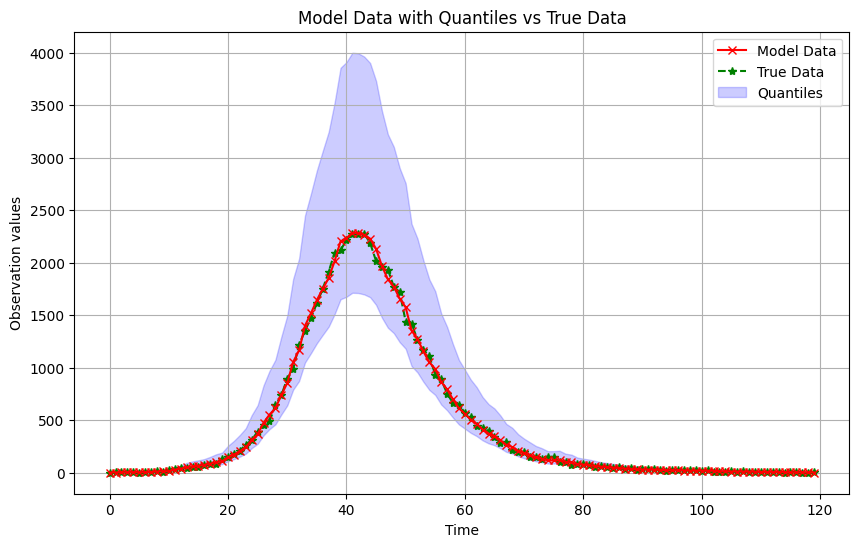

In [17]:
plots.model_fit(output=output, node_index=0)

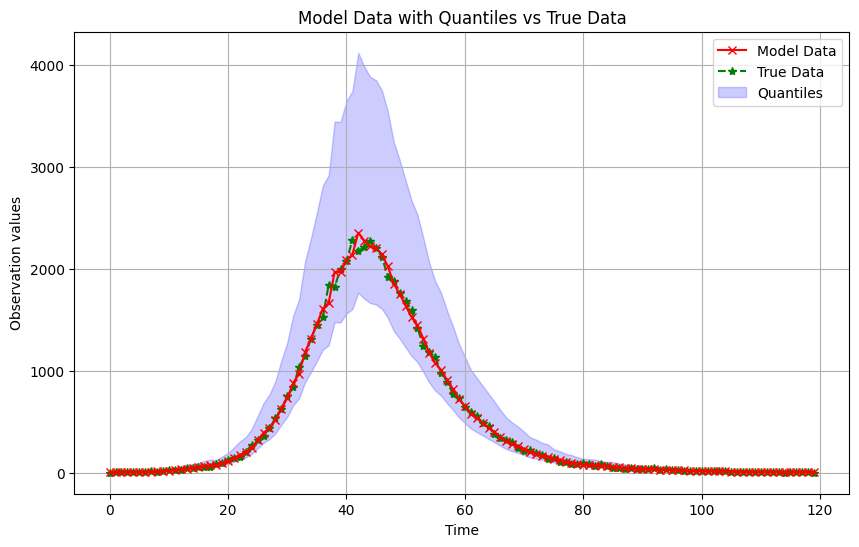

In [18]:
plots.model_fit(output=output, node_index=1)